In [1]:
import os
EXAMPLE_DIR = os.getcwd()
os.chdir(os.path.join('..', '..'))
PROJECT_DIR = os.getcwd()
print('EXAMPLE_DIR: ', EXAMPLE_DIR)
print('PROJECT_DIR: ', PROJECT_DIR)

EXAMPLE_DIR:  /home/karan/Documents/research/regret_syn_toolbox/regret_synthesis_toolbox/examples/FishAndShipwreckAvoidAgent
PROJECT_DIR:  /home/karan/Documents/research/regret_syn_toolbox/regret_synthesis_toolbox


In [2]:
%load_ext autoreload
%autoreload 2
import gym
from IPython.display import Video, display

import sys
import time
import numpy as np
from pathlib import Path

sys.path.append(os.path.join(PROJECT_DIR, 'src'))
from src.graph import Graph
from src.graph import graph_factory
from src.config import ROOT_PATH
from src.strategy_synthesis.multiobjective_solver import MultiObjectiveSolver
from src.simulation.simulator import Simulator

sys.path.append(os.path.join(PROJECT_DIR, 'wombats'))
from wombats.systems.minigrid import GYM_MONITOR_LOG_DIR_NAME
from wombats.systems.minigrid import DynamicMinigrid2PGameWrapper, MultiAgentMiniGridEnv

DIR = EXAMPLE_DIR
Graph.graph_dir = DIR

In [3]:
debug = True

env_id = 'MiniGrid-FishAndShipwreckAvoidAgent-v0'
pdfa_config_yaml="config/PDFA_Fish_and_Shipwreck"
player_steps = {'sys': [1, 3], 'env': [1]}

load_game_from_file = False
plot_minigrid = False
plot_pdfa = True
plot_product = False
finite = True
view = True
save_flag = True
format = 'png'

stochastic = False
adversarial = True
plot_strategies=False
plot_graph_with_strategy = False
plot_graph_with_pareto = False
plot_pareto = True
speedup = True

env_filename = os.path.join(DIR, 'plots', 'gym_env.png')
Path(os.path.split(env_filename)[0]).mkdir(parents=True, exist_ok=True)
env_dpi = 300

/home/karan/Documents/research/regret_syn_toolbox/regret_synthesis_toolbox/examples/FishAndShipwreckAvoidAgent/plots/pdfa.png


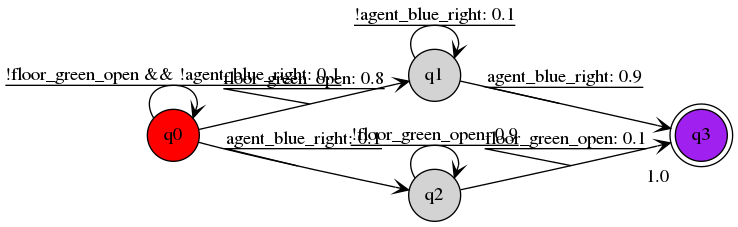

In [4]:
# PDFA
pdfa = graph_factory.get(
    'PDFA',
    graph_name="pdfa",
    config_yaml=pdfa_config_yaml,
    save_flag=save_flag,
    plot=plot_pdfa,
    view=view,
    format=format)

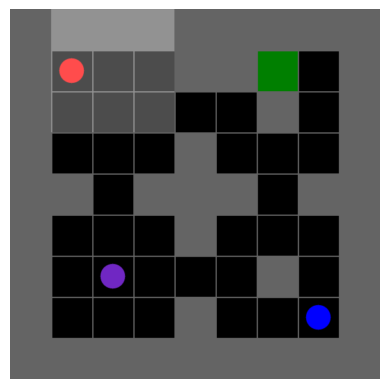

In [5]:

# OpenAI Minigrid Env
env = gym.make(env_id)
env = DynamicMinigrid2PGameWrapper(
        env,
        player_steps=player_steps,
        monitor_log_location=os.path.join(DIR, GYM_MONITOR_LOG_DIR_NAME))
env.reset()
env.render_notebook(env_filename, env_dpi)

In [6]:
file_name = env_id + 'Game'
filepath = os.path.join(DIR, 'config', file_name)
config_yaml = os.path.relpath(filepath, ROOT_PATH)

# Game Construction
start = time.time()
two_player_graph = graph_factory.get('TwoPlayerGraph',
                            graph_name='TwoPlayerGame',
                            config_yaml=config_yaml,
                            from_file=load_game_from_file,
                            minigrid=env,
                            save_flag=save_flag,
                            plot=plot_minigrid,
                            view=view,
                            format=format)
end = time.time()

In [7]:
# Product Game Construction
file_name = env_id + 'ProductAutomaton'
# config_yaml = os.path.join(DIR, 'config', file_name)
config_yaml = None

start = time.time()
game = graph_factory.get('ProductGraph',
    graph_name='ProductAutomaton',
    config_yaml=config_yaml,
    trans_sys=two_player_graph,
    automaton=pdfa,
    save_flag=True,
    prune=False,
    debug=False,
    absorbing=True,
    finite=finite,
    plot=plot_product,
    integrate_accepting=True,
    pdfa_compose=True,
    view=view,
    format=format)
end = time.time()
print(f'Product Construction took {end-start:.2f} seconds')

Product Construction took 9.54 seconds


In [8]:
solver = MultiObjectiveSolver(game,
                            epsilon=1e-5,
                            max_iteration=300,
                            stochastic=stochastic,
                            adversarial=adversarial)
solver.solve(plot_strategies=plot_strategies,
                plot_graph_with_strategy=plot_graph_with_strategy,
                plot_graph_with_pareto=plot_graph_with_pareto,
                plot_pareto=plot_pareto,
                speedup=speedup,
                debug=debug,
                view=view,
                format=format)

TypeError: '>' not supported between instances of 'list' and 'int'

In [10]:
iterations = 100
iterations = 1

for pp in solver.get_pareto_points():
        strategy = solver.get_a_strategy_for(pp)

        print('-'*100)
        print(f"Evaluate for a pareto point {pp}")
        print('-'*100)

        sim = Simulator(env, game)
        sim.run(iterations=iterations,
                sys_strategy=strategy,
                render=False,
                record_video=iterations<=15)
        sim.get_stats()
        # sim.plot_grid()

----------------------------------------------------------------------------------------------------
Evaluate for a pareto point [46.         31.51401394]
----------------------------------------------------------------------------------------------------
Maximum Costs [46.         27.11956479]
Observation {('agent_blue_right', 'agent_blue_right', 'floor_green_open'): 1}
----------------------------------------------------------------------------------------------------
Evaluate for a pareto point [40.         40.72435432]
----------------------------------------------------------------------------------------------------
Maximum Costs [40.         36.32990516]
Observation {('agent_blue_right', 'floor_green_open'): 1}
----------------------------------------------------------------------------------------------------
Evaluate for a pareto point [59.       20.013511]
----------------------------------------------------------------------------------------------------
Maximum Costs [59.  

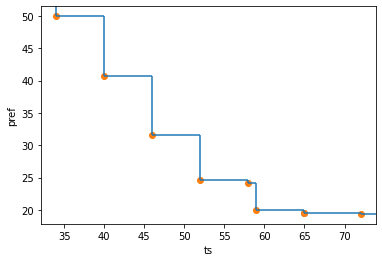

In [11]:
import matplotlib.pyplot as plt
costs = []
for result in sim._results:
    costs.append(result['Cost'])

costs = np.array(costs)

fig = plt.figure()
ax = fig.add_subplot(111)
ax.scatter(costs[:, 0], costs[:, 1])

solver.plot_pareto_front(ax)

# Evaluation

In [ ]:
# TODO: FIX THIS SHIT

player = 'sys'
SYS_ACTIONS = []
for multiactions in env.player_actions[player]:
    action_strings = []
    for agent, actions in zip(env.unwrapped.agents, multiactions):
        action_string = []
        for action in actions:
            if action is None or np.isnan(action):
                continue
            a_str = agent.ACTION_ENUM_TO_STR[action]
            action_string.append(a_str)
        action_strings.append(tuple(action_string))
    action_strs = action_strings[0] if player == 'sys' else action_strings[1:]
    SYS_ACTIONS.append(tuple(action_strs))

player = 'env'
ENV_ACTIONS = []
for multiactions in env.player_actions[player]:
    action_strings = []
    for agent, actions in zip(env.unwrapped.agents, multiactions):
        action_string = []
        for action in actions:
            if action is None or np.isnan(action):
                continue
            a_str = agent.ACTION_ENUM_TO_STR[action]
            action_string.append(a_str)
        action_strings.append(tuple(action_string))
    action_strs = action_strings[0] if player == 'sys' else action_strings[1:]
    ENV_ACTIONS.append(tuple(action_strs))

print(SYS_ACTIONS)
print(ENV_ACTIONS)

[('north',), ('south',), ('east',), ('west',), ('north', 'north', 'north'), ('north', 'north', 'south'), ('north', 'north', 'east'), ('north', 'north', 'west'), ('north', 'south', 'north'), ('north', 'south', 'south'), ('north', 'south', 'east'), ('north', 'south', 'west'), ('north', 'east', 'north'), ('north', 'east', 'south'), ('north', 'east', 'east'), ('north', 'east', 'west'), ('north', 'west', 'north'), ('north', 'west', 'south'), ('north', 'west', 'east'), ('north', 'west', 'west'), ('south', 'north', 'north'), ('south', 'north', 'south'), ('south', 'north', 'east'), ('south', 'north', 'west'), ('south', 'south', 'north'), ('south', 'south', 'south'), ('south', 'south', 'east'), ('south', 'south', 'west'), ('south', 'east', 'north'), ('south', 'east', 'south'), ('south', 'east', 'east'), ('south', 'east', 'west'), ('south', 'west', 'north'), ('south', 'west', 'south'), ('south', 'west', 'east'), ('south', 'west', 'west'), ('east', 'north', 'north'), ('east', 'north', 'south'), (

In [ ]:
pp = solver.get_pareto_points()[0]
strategy = solver.get_a_strategy_for(pp)

# Goes into Water 
sys_actions = [
    SYS_ACTIONS[2], 
    SYS_ACTIONS[2], 
    SYS_ACTIONS[2], 
    SYS_ACTIONS[0], 
    SYS_ACTIONS[2], 
    SYS_ACTIONS[2],
    SYS_ACTIONS[1], 
    SYS_ACTIONS[2], 
    SYS_ACTIONS[2],
    SYS_ACTIONS[0],
    SYS_ACTIONS[0],
    SYS_ACTIONS[0],
    SYS_ACTIONS[2],
    SYS_ACTIONS[1],
    SYS_ACTIONS[1],
    SYS_ACTIONS[1],
    ]

sim = Simulator(env, game)
sim.run_turn_based_game(
    sys_actions=sys_actions,
    # env_actions=env_actions,
    render=False,
    record_video=True)
sim.get_stats()

Exception: No more actions to take

In [ ]:
env_actions = [
    ENV_ACTIONS[3], 
    ENV_ACTIONS[1], 
    ENV_ACTIONS[3], 
    ENV_ACTIONS[2], 
    ENV_ACTIONS[2], 
    ENV_ACTIONS[2],
    ENV_ACTIONS[2],
    ENV_ACTIONS[2],
    ENV_ACTIONS[1],
    ENV_ACTIONS[1],
    ENV_ACTIONS[1],
    ENV_ACTIONS[1],
    ENV_ACTIONS[1],
    ENV_ACTIONS[1],
    ENV_ACTIONS[1],
    ENV_ACTIONS[1],
    ]

sim = Simulator(env, game)
sim.run_turn_based_game(
    sys_strategy=strategy,
    env_actions=env_actions,
    render=False,
    record_video=True)
sim.get_stats()

Maximum Costs [54.          4.35169905]
Observation {('floor_green_open',): 1}
